In [1]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [58]:
%matplotlib inline
def intrinsic_func(x,mu,dt):
    return mu*np.sin(x+dt)

x=np.random.rand(200)*6;x=np.sort(x)
sigfx=0.2+np.random.rand(len(x))


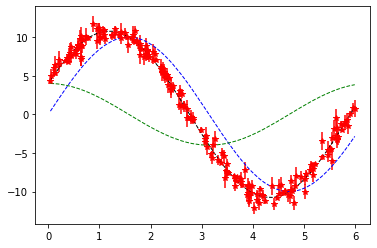

In [59]:
#mu and dt for the images
mu_l=[10.0,4.0,3.5]
dt_l=[0.0,1.57,0.5]
#for simplicity just consider the 1st NI images for now
NI=2;  
fx=np.zeros((NI,len(x)))
for i in np.arange(NI): 
    fx[i]=intrinsic_func(x,mu_l[i],dt_l[i])
    
fx_total=np.sum(fx,axis=0)

y=np.random.normal(fx_total, sigfx)

plt.errorbar(x,y,yerr=sigfx,fmt='r*')
plt.plot(x,fx_total,c='k',lw=1.0,ls="--")
clr=["b","g","c"]
for i in range(NI):
    plt.plot(x,fx[i],c=clr[i],lw=1.0,ls="--")

plt.show()

In [60]:
#with lmfit minimization
p = lmfit.Parameters()

p.add_many(('mu1', 1.0),('mu2', 1.0),('dt1', 1.0),)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)+v['mu2']*np.sin(x+v['dt1']) - y)/sigfx

print(p)
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
print(mi)
#p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

#res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=200,
#                     params=mi.params, is_weighted=False)
#lmfit.report_fit(res.params)

Parameters([('mu1', <Parameter 'mu1', 1.0, bounds=[-inf:inf]>), ('mu2', <Parameter 'mu2', 1.0, bounds=[-inf:inf]>), ('dt1', <Parameter 'dt1', 1.0, bounds=[-inf:inf]>)])
[[Variables]]
    mu1:  9.15296451 +/- 2998429.11 (32759103.41%) (init = 1)
    mu2:  4.02588778 +/- 571020.013 (14183704.16%) (init = 1)
    dt1:  1.37918627 +/- 731156.619 (53013623.80%) (init = 1)
[[Correlations]] (unreported correlations are < 0.500)
    C(mu1, dt1) =  1.000
    C(mu1, mu2) = -1.000
    C(mu2, dt1) = -1.000


In [62]:
#with lmfit emcee
%reset_selective -f mi
p = lmfit.Parameters()

p.add_many(('mu1', 8.0, True, 1.0,20.0),('mu2', 4.0,True, 1.0,10.0))
p.add('dt1', value=1.50, min=0.0, max=2.0)
print(p)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)+v['mu2']*np.sin(x+v['dt1']) - y)/sigfx

print(p)
#mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
#lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
#print(mi)
p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=50,
                     params=p, is_weighted=False)
lmfit.report_fit(res.params)

  2%|▏         | 16/1000 [00:00<00:06, 155.12it/s]

Parameters([('mu1', <Parameter 'mu1', 8.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 4.0, bounds=[1.0:10.0]>), ('dt1', <Parameter 'dt1', 1.5, bounds=[0.0:2.0]>)])
Parameters([('mu1', <Parameter 'mu1', 8.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 4.0, bounds=[1.0:10.0]>), ('dt1', <Parameter 'dt1', 1.5, bounds=[0.0:2.0]>)])


100%|██████████| 1000/1000 [00:04<00:00, 215.30it/s]

[[Variables]]
    mu1:        6.21791962 +/- 3.52448322 (56.68%) (init = 8)
    mu2:        5.42331962 +/- 2.02613121 (37.36%) (init = 4)
    dt1:        0.81567086 +/- 0.52891827 (64.84%) (init = 1.5)
    __lnsigma:  0.01210888 +/- 0.05142119 (424.66%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, dt1) =  0.971
    C(mu1, mu2) = -0.962
    C(mu2, dt1) = -0.873


In [63]:
#using mcmc

def log_likelihood(theta, x, y, yerr): 
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    dp=len(x);
    fxx=np.zeros((NI,dp))
    for i in np.arange(NI):
        fxx[i]=mu[i]*np.sin(x+dt[i])#/np.power(x,pr)
        
    model =np.sum(fxx,axis=0) #mu*np.sin(x)/np.power(x,pr)
    sigma2 = yerr**2;#yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 /sigma2)

def log_prior(theta):
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    if 1.0 < mu[0] < 10.0 and 1.0 < mu[1] < 10.0 and 0 < dt1 <2:# and 0.0 < pr < 2.0:# and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

p0=np.array([1.0,1.5,0.0]);
Npar=len(p0); Nwalker=200
pos = p0 + 1e-4 * np.random.randn(Nwalker, Npar)
nwalkers, ndim = (Nwalker, Npar)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sigfx))
xxx1=sampler.run_mcmc(pos,2000);

In [64]:
flat_samples = sampler.get_chain(discard=200, thin=7, flat=True)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [2.5,16,25, 50,75, 84,97.5])
    print(mcmc)

[1.6530901  4.05572715 5.0101877  6.94546604 8.54710883 9.06952331
 9.85916456]
[3.92355671 4.05087255 4.18948612 4.94838816 6.30485468 7.06852208
 9.14866727]
[0.44603289 0.59321896 0.67729358 0.92529033 1.23655387 1.35808158
 1.55375106]


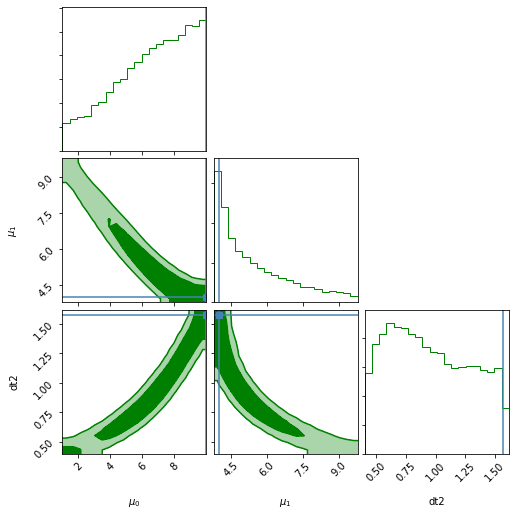

In [65]:
import corner
samples1 = sampler.chain[:, 300:, ].reshape((-1, 3))
fig1 = corner.corner(samples1, labels=[r"$\mu_1$",r"$\mu_2$","dt2"],
                        color='g', smooth=1,
                        levels=(0.68,0.95), plot_density=0, fill_contours=1, plot_datapoints=0, truths=[mu_l[0],mu_l[1], dt_l[1]])

In [67]:
model = """
data {
    int<lower=0> N;
    int<lower=0> np;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [np];
    real <lower=-2, upper=2> dt[np-1];
    //real sig;
    
}
model {
    real dum;
    real ddtt;
    for(i in 1:N) {
        dum=0;
        for (j in 1:np){
            ddtt=dt[1];
            if(j==1){ddtt=0;}
            dum=dum+mu[j]*sin(x[i]+ddtt);
        }
        //y[i] ~ normal((mu*sin(x[i])/pow(x[i],pr)), yerror[i]);
        y[i] ~ normal(dum, yerror[i]);
    }
}
"""
# Put our data in a dictionary
data = {'N': len(x),'np':NI, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1df7c204825e6d8256ad02c8d2941719 NOW.


Inference for Stan model: anon_model_1df7c204825e6d8256ad02c8d2941719.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   7.36    0.13   2.77   1.69   5.25   7.69   9.67  11.54    442   1.02
mu[2]   5.25    0.07   1.49   3.91   4.09   4.55   6.12   9.13    433   1.02
dt[1]   1.12    0.02   0.46   0.45    0.7   1.05    1.5   1.96    474   1.01
lp__  -100.0    0.05   1.31 -103.4 -100.6 -99.71 -99.05 -98.47    661    1.0

Samples were drawn using NUTS at Mon Nov 18 13:01:20 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [68]:
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [ni];
    real <lower=1, upper=2> dt[ni-1];
    vector <lower=-1, upper=1> [NP] P;
    //real sig;
    
}
model {
    real dum;
    vector[NP] tm;
    real td=1.0;
    real dum_t;
    int ti;
    real dtt;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum_t=x[i];
        dum=0;
        for (j in 1:ni){
            dtt=dt[1];
            if(j==0){dtt=0;}
            dum_t=dum_t+dtt;
            while(dum_t<ti*td){
                ti=ti+1;
            }
            mod_intr_f=P[ti+1]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td);
            dum+=mu[i]*mod_intr_f;
        }
        y[i] ~ normal(dum, yerror[i]);
        
    }
}
"""
NP=9;
# Put our data in a dictionary
data = {'N': len(x),'ni':NI,'NP':NP, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de44f6c4eee609768a2d18b784b7123c NOW.


RuntimeError: Exception: []: accessing element out of range. index -2147483647 out of range; expecting index to be between 1 and 9; index position = 1P  (in 'unknown file name' at line 37)


In [ ]:
tt=np.array([1,2,4,6])
if all(i < 4)

In [59]:
np.concatenate((mu_l,dt_l))

array([10. ,  4. ,  3.5,  0. ,  1.5,  0.5])